# How to Remove Non-Stationarity in Time Series Forecasting
## Algorithms can't handle non-stationary. They need static relationships.
![](images/unsplash.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://unsplash.com/@jonathanpielmayer?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText'>Jonathan Pielmayer</a>
        on 
        <a href='https://unsplash.com/s/photos/still?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText'>Unsplash.</a> All images are by author unless specified otherwise.
    </strong>
</figcaption>

## Setup

In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")
plt.style.use("ggplot")

## Introduction

Unlike ordinary machine learning problems, time series forecasting requires *extra* preprocessing steps.

On top of the normality assumptions, most ML algorithms expect a *static relationship* between the input features and the output.

A static relationship requires inputs and outputs with constant parameters such as mean, median, and variance. In other words, algorithms perform best when the inputs and outputs are **stationary**.

This is not the case in time series forecasting. Distributions that change over time can have unique properties such as seasonality and trend. These, in turn, cause the mean and variance of the series to fluctuate, making it hard to model their behavior.

So, making a distribution stationary is a strict requirement in time series forecasting. In this article, we will explore several techniques to detect non-stationary distributions and convert them into stationary data.

> You can access all the articles in this Time Series Forecasting series from [here](https://ibexorigin.medium.com/list/time-series-forecast-from-scratch-c72ccf7a9229).

## Why is stationarity important?

If a distribution is not stationary, then it becomes tough to model. Algorithms build relationships between inputs and outputs by estimating the core parameters of the underlying distributions.

When these parameters are all time-dependent, algorithms will face different values at each point in time. And if the time series is granular enough (such as minutes or seconds frequencies), models may even end up with more parameters than actual data.

This type of variable relationship between inputs and outputs will seriously compromise the decision function of any model. If the relationship keeps changing through time, models end up using an outdated relationship or one that does not contribute to its predictive power.

Therefore, you must dedicate a certain amount of time to detecting non-stationarity and removing its effects during your workflow.

We will see an example of this in the coming sections.

## Examples of non-stationary series

Take a look at these plots and try to guess which of the lines represent a stationary series:

![](https://otexts.com/fpp2/fpp_files/figure-html/stationary-1.png)
<figcaption style="text-align: center;">
    <strong>
        Image by <a href='https://otexts.com/fpp2/'>otexts.com</a> [1]
    </strong>
</figcaption>

Since stationary series have constant variance, we can rule out **a, c, e, f**, and **i**. These plots show a clear upward or downward trend or changing levels like in f.

Similarly, as **d **and **h** show seasonal patterns, we can rule them out too. 

But how about **g** - the pattern does look it is seasonal.

**g** is the plot of the [lynx](https://en.wikipedia.org/wiki/Lynx) population growth. When food becomes scarce, they stop breeding, causing the population numbers to plummet. When the food sources replenish, they start reproducing again, making the population grow.

This cyclic behavior is not the same as seasonality. When seasonality exists, you know exactly what will happen after a certain period of time. In contrast, the cyclic behavior of lynx population growth is unpredictable. You can't guess the timing of the food cycles and this makes the series stationary.
So, the only stationary series are b and g.

Tricky distributions like **d, f**, and **h** can make you question whether identifying non-stationary data visually is the best option. As you observed, it is pretty easy to confuse seasonality with random cycles or trends with white noise.

For this reason, the next section will be about statistical methods of detecting non-stationary time series.

## Detecting non-stationarity statistically

In the statistics world, there are several tests under the label of [unit root tests](https://medium.com/r/?url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FUnit_root_test%23%3A~%3Atext%3DIn%2520statistics%252C%2520a%2520unit%2520root%2Cdepending%2520on%2520the%2520test%2520used.). The augmented Dickey-Fuller test may be the most popular one, and we have already seen how to use it to detect random walks in [my last kernel](https://www.kaggle.com/bextuychiev/how-to-detect-white-noise-and-random-walks-in-ts).

Here, we will see how to use it to check if a series is stationary or not.

Simply put, here are the null and alternative hypotheses of this test:
- **The null hypothesis**: the distribution is non-stationary, time-dependent (it has a unit root)
- **The alternative hypothesis**: the distribution is stationary, not time-dependent (can't be represented by a unit root).

The p-value determines the result of the test. If it is smaller than a critical threshold of 0.05 or 0.01, we **reject** the null hypothesis and conclude that the series is stationary. Otherwise, we **fail to reject** the null and conclude the series is non-stationary.

The full test is conveniently implemented as `adfuller` function under `statsmodels`. First, let's use it on a distribution we know is stationary and get familiarized with its output:

In [3]:
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

diamonds = sns.load_dataset("diamonds")

test_results = adfuller(diamonds["price"])

print(f"ADF test statistic: {test_results[0]}")
print(f"p-value: {test_results[1]}")
print("Critical thresholds:")
for key, value in test_results[4].items():
    print(f"\t{key}: {value}")

ADF test statistic: -8.1149306683156
p-value: 1.1980457313376738e-12
Critical thresholds:
	1%: -3.430471308341908
	5%: -2.8615936158814588
	10%: -2.566798537945544


We look at the p-value, which is almost 0. This means we can easily reject the null and consider the distribution as stationary.

Now, let's load the TPS July Playground dataset from Kaggle and check if the target carbon monoxide is stationary:

In [4]:
tps_july = pd.read_csv(
    "data/tps_july_train.csv", parse_dates=["date_time"], index_col="date_time"
)

test_results = adfuller(tps_july["target_carbon_monoxide"])

test_results[1]

7.26341357249666e-15

Surprisingly, carbon monoxide is found to be stationary. This might be because the data is recorded over a short period of time, which diminishes the effect of the time component. In fact, all other variables in the data are completely stationary.

Now, let's load some stocks data that is more likely to be non-stationary:

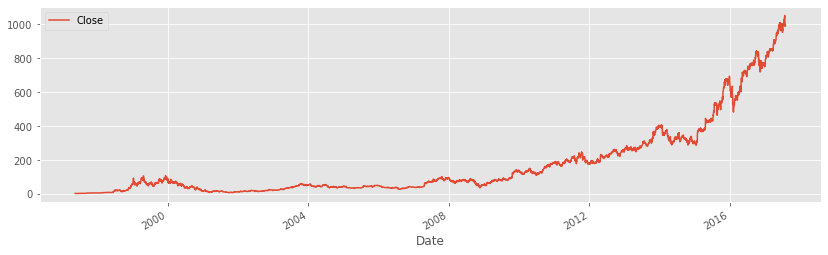

In [5]:
amzn = pd.read_csv("data/AMZN.csv", parse_dates=["Date"], index_col="Date")

amzn.plot(figsize=(14, 4));

As you can see, Amazon stocks show a clear upward trend. Let's perform the Dickey-Fuller test:

In [6]:
amzn_results = adfuller(amzn["Close"])

amzn_results[1]

1.0

We get a perfect p-value of 1 - this is 100% non-stationary time series data. Let's perform a final test on Microsoft stocks, and we will move on to different techniques you can deal with this type of data:

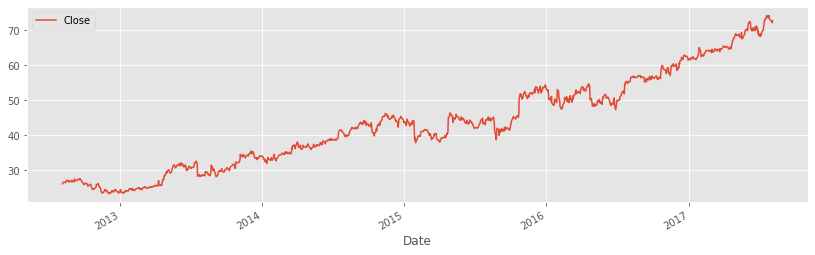

In [7]:
msft = pd.read_csv("data/MSFT.csv", parse_dates=["Date"], index_col="Date").dropna()

msft.plot(figsize=(14, 4));

In [8]:
msft_results = adfuller(msft["Close"])

msft_results[1]

0.9711208852369689

The p-value is close to 1. No interpretation is necessary.

## Transforming non-stationary series to make it stationary

One method for transforming the simplest non-stationary data is differencing. This process involves taking the differences of consecutive observations. Pandas has a `diff` function to do this:

In [10]:
msft["diff_1"] = msft["Close"].diff(periods=1)
msft["diff_2"] = msft["Close"].diff(periods=2)
msft["diff_3"] = msft["Close"].diff(periods=3)

msft.head(6)

,Close,diff_1,diff_2,diff_3
Date,,,,
2012-08-06,26.107651,NaN,NaN,NaN
2012-08-07,26.377876,0.270225,NaN,NaN
2012-08-08,26.438896,0.061020,0.331245,NaN
2012-08-09,26.587088,0.148192,0.209212,0.479437
2012-08-10,26.517351,-0.069737,0.078455,0.139475
2012-08-13,26.491201,-0.026150,-0.095887,0.052305


The output above shows the results of first, second, and third-order differencing.

For simple distributions, taking the first-order difference is enough to make it stationary. Let's check this by using the `adfuller` function on the `diff_1` (first-order difference of Microsoft stocks):

In [11]:
results = adfuller(msft["diff_1"].dropna())

results[1]

0.0

When we run `adfuller` on the original distribution of Microsoft stocks, the p-value was close to 1. after differencing, the p-value is flat 0, suggesting we reject the null and conclude the series is now stationary.

However, some distributions may not be so easy to deal with. Going back to Amazon stocks:

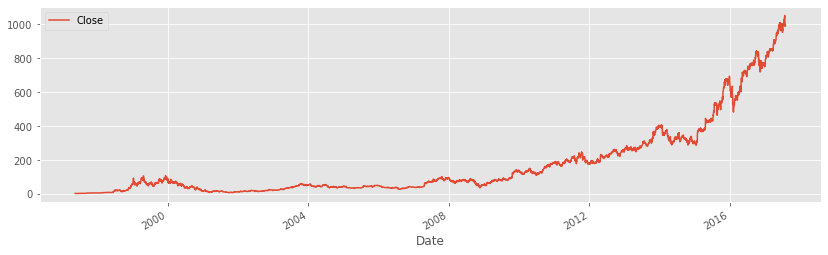

In [12]:
amzn.plot(figsize=(14, 4));

Before taking the difference, we have to account for that obvious non-linear trend. Otherwise, the series will still be non-stationary.

To remove non-linearity, we will use the logarithmic function `np.log` and then, take the first-order difference:

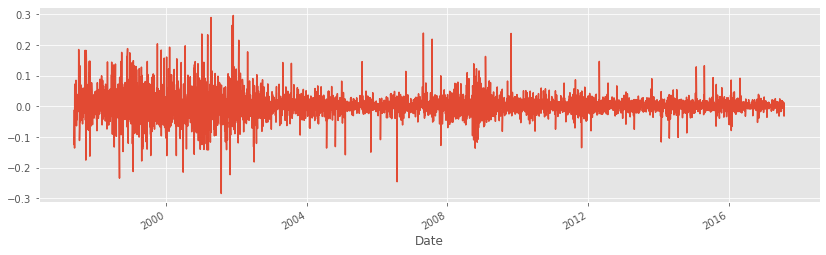

In [13]:
transformed_amzn = pd.Series(np.log(amzn["Close"])).diff().dropna()

transformed_amzn.plot(figsize=(14, 4));

In [14]:
results = adfuller(transformed_amzn)

results[1]

1.9177281093251045e-22

As you can see, the distribution that returned a perfect p-value before transformation is now completely stationary.

Let's look at another example. Below is the plot of monthly antibiotics sales in Australia:

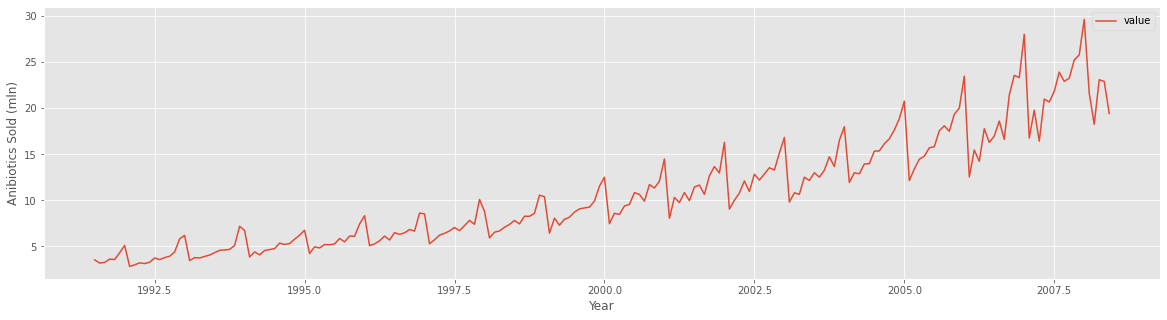

In [15]:
drugs = pd.read_csv("data/australia_drug_sales.csv", index_col=0)

drugs.plot("time", "value", figsize=(20, 5))
plt.xlabel("Year")
plt.ylabel("Anibiotics Sold (mln)");

As you can see, the series shows both an upward trend and a strong seasonality. We will again apply a log transform and, this time, take a yearly difference (12 months) to remove the seasonality.

Here is what each step looks like:

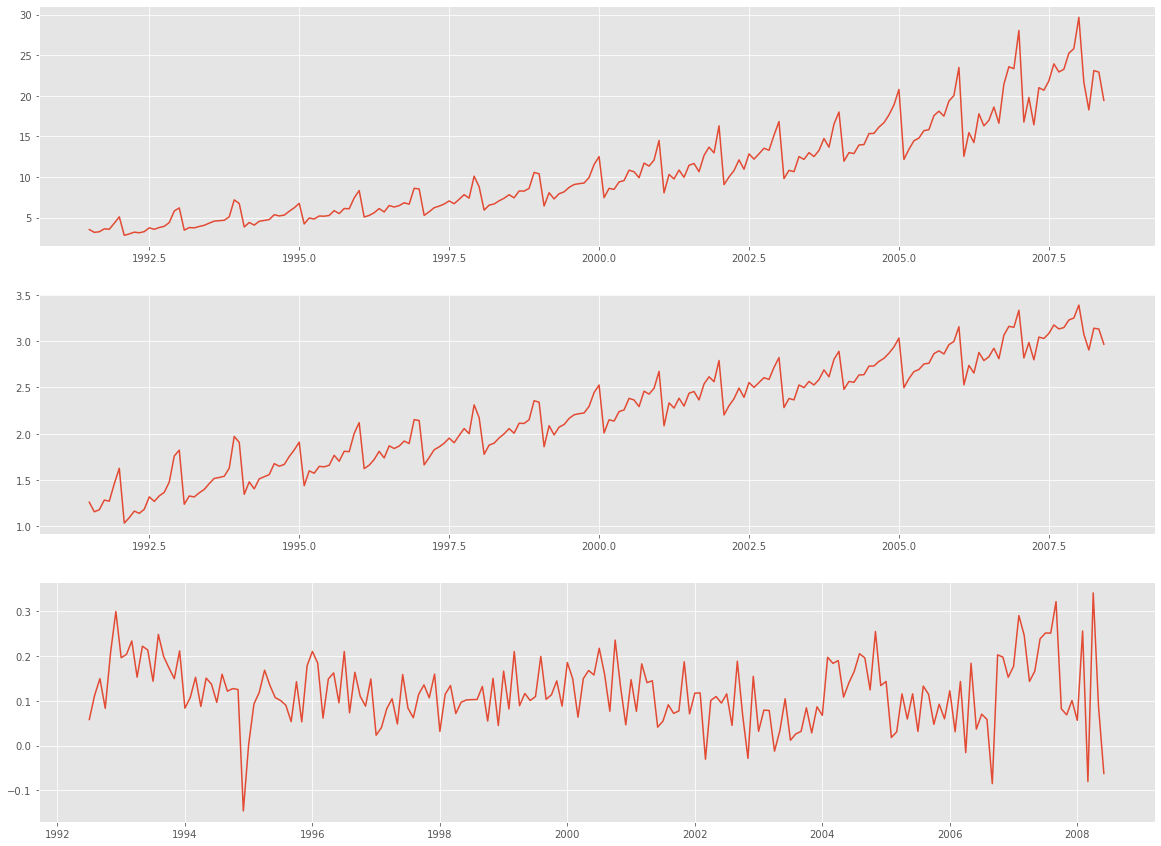

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15))

ax[0].plot(drugs["time"], drugs["value"], label="Original series")
ax[1].plot(drugs["time"], np.log(drugs["value"]), label="After log transform")

drugs["transformed"] = pd.Series(np.log(drugs["value"])).diff(periods=12)  # 12 months
drugs.dropna(inplace=True)
ax[2].plot(drugs["time"], drugs["transformed"], label="After differencing");

We can confirm the stationarity with `adfuller`:

In [17]:
results = adfuller(drugs["transformed"])

results[1]

8.209874468611354e-06

The p-value is extremely small, proving that the transformation steps have shown their effect.

In general, every distribution is different, and to achieve stationarity, you might end up chaining multiple operations. Most of these involve taking logarithms, first/second-order, or seasonal differencing.

## Summary

Another topic is done and dusted in this Time Series forecasting series!

We have already covered a lot, even though we haven't gotten around to the actual forecasting part. By now, you should be able to:

- Manipulate time-series data like a pro using pandas ([link](https://towardsdatascience.com/every-pandas-function-you-can-should-use-to-manipulate-time-series-711cb0c5c749?source=your_stories_page-------------------------------------)).
- Dissect any time series into core components such as seasonality and trend ([link](https://towardsdatascience.com/advanced-time-series-analysis-in-python-decomposition-autocorrelation-115aa64f475e?source=your_stories_page-------------------------------------)).
- Analyze time-series signals using autocorrelation ([link](https://towardsdatascience.com/advanced-time-series-analysis-in-python-decomposition-autocorrelation-115aa64f475e?source=your_stories_page-------------------------------------)).
- Identify if the target you want to predict is white noise or follows a random walk ([link](https://towardsdatascience.com/how-to-detect-random-walk-and-white-noise-in-time-series-forecasting-bdb5bbd4ef81?source=your_stories_page-------------------------------------)).

And finally, you learned how to remove the effect of non-stationary from any time series. All of these are must-know topics and important building blocks to forecasting. The next post is on time-series feature engineering. [Don't miss it](https://ibexorigin.medium.com/)!

### You might also be interested ...
- [Matplotlib vs. Plotly: Let’s Decide Once and for All](https://towardsdatascience.com/matplotlib-vs-plotly-lets-decide-once-and-for-all-ad25a5e43322?source=your_stories_page-------------------------------------)
- [5 Super Productive Things To Do While Training Machine Learning Models](https://towardsdatascience.com/5-short-but-super-productive-things-to-do-during-model-training-b02e2d7f0d06?source=your_stories_page-------------------------------------)
- [6 Things I Do to Consistently Improve My Machine Learning Models](https://towardsdatascience.com/6-things-i-do-to-consistently-improve-my-machine-learning-models-36cd87aaf9fd?source=your_stories_page-------------------------------------)